In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import math
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import geopy.distance
from scipy import stats
from scipy.integrate import quad

# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Additional Commands to Run:
# pip install cartopy
# pip uninstall shapely
# pip install shapely --no-binary shapely

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# SAMPLING THE INITIAL PARAMETERS FOR SCENARIOS #

# generates a value of RMW (in nautical miles) using Kernel Density Estimate
def generate_sample_RMW():
  data = np.array([4.5, 5.5, 8.633, 10.039, 10.269, 8.757, 10.468, 7.29, 9.785, 8.673, 10.032, 9.296, 9.815, 8.457, 7.582, 7.513, 7.363, 9.284, 10.362, 8.71, 9.382, 10.473, 7.091, 9.757, 13.888, 13.685, 13.463, 12.62, 11.887, 12.938, 10.968, 12.124, 12.04, 10.909, 11.443, 12.379, 10.659, 11.884, 13.203, 10.652, 20.899, 17.785, 20.867, 17.981, 19.692, 20.449, 18.181, 18.754, 17.934, 18.929, 19.623, 17.881, 18.585, 20.726, 19.57, 19.266, 20.818, 19.428, 17.913, 18.282, 19.636, 18.773, 27.517, 26.665, 26.377, 26.425, 26.676, 24.7, 26.213, 27.55, 32.502, 32.31, 31.627, 34.201, 34.559, 33.656, 34.168, 33.779, 32.28, 33.48, 33.612, 33.38, 35.914, 37.559, 40.065, 39.424, 39.434, 40.855, 41.711, 39.613, 38.879, 40.521])
  # bw = 1. / np.std(data)
  g_kde = stats.gaussian_kde(dataset=data, bw_method=0.35)
  sample = g_kde.resample(1)
  value = sample[0][0]

  if (value < 0.5):
    return 0.5;

  return value

# generates a value of RS (in nautical miles) using Kernel Density Estimate
def generate_sample_RS():
  data = np.array([125.905, 144.917, 140.757, 141.08, 125.112, 134.245, 140.044, 149.898, 144.786, 138.548, 163.761, 168.162, 176.488, 180.591, 222.465, 222.429, 200.777, 215.574, 241.822, 246.177, 246.968, 239.157, 232.497, 233.106, 238.579, 234.642, 245.754, 236.565, 246.414, 229.196, 234.342, 225.049, 227.999, 252.837, 258.687, 274.109, 268.347, 263.399, 258.522, 291.296, 298.1, 287.079, 292.886, 277.824, 286.143, 279.59, 277.853, 321.407, 322.538, 320.277, 311.371, 305.598, 324.98, 332.034, 335.154, 331.389, 343.105, 349.919, 339.735, 356.333, 373.597, 357.31, 360.001, 356.86, 367.073])
  bw = 1. / np.std(data)
  g_kde = stats.gaussian_kde(dataset=data, bw_method=0.35)
  sample = g_kde.resample(7)
  value = sample[0]

  return value

# generates a value of WM (in knots) using Kernel Density Estimate
def generate_sample_WM():
  data = np.array([100.249, 102.907, 104.016, 103.428, 101.597, 105.601, 100.342, 101.32, 101.947, 101.754, 103.18, 105.719, 104.022, 102.299, 100.566, 104.039, 102.868, 104.885, 103.966, 100.543, 102.881, 103.439, 103.504, 104.424, 105.782, 102.982, 103.86, 103.001, 101.555, 105.739, 105.688, 102.446, 102.552, 102.863, 101.022, 103.733, 103.248, 100.832, 101.671, 104.6, 100.478, 101.967, 100.516, 104.504, 104.821, 102.403, 105.345, 104.873, 107.237, 109.737, 106.047, 111.458, 109.363, 106.038, 111.275, 109.977, 106.432, 106.404, 110.429, 107.832, 116.77, 113.746, 113.014, 112.545, 115.294, 116.933, 120.623, 121.423, 126.301, 125.773, 128.938, 125.39, 125.444, 125.082, 126.626, 125.045, 141.2, 143.0, 145])
  # bw = 1. / np.std(data)
  g_kde = stats.gaussian_kde(dataset=data, bw_method=0.35)
  sample = g_kde.resample(1)
  value = sample[0][0]

  return value

In [ ]:
# INITIAL PARAMETERS #
# ------------------------ #
# CONSTANTS #
NUM_SCENARIOS_PER_TRACK = 10   # this means that the total number of scenarios will be NUM_SCENARIOS_PER_TRACK * NUM_TRACK = 10*3 = 30

# radius of maximum wind (nautical miles)
rmw = generate_sample_RMW()
if (rmw > 43.5):
  rmw = 43.5
# maximum sustained wind (knots)
wm = generate_sample_WM()
# radius of smallest wind (nautical miles)
rs_path = generate_sample_RS()
B = 10
K = 1.14
α = 0.04

Ξ = K * wm
Ψ = 1/(rmw)*math.log(K/(K-1))

# x and y coordinates of the eye of the hurricane
eyeX = -95.2
eyeY = 28.9
hurricanePath_1 = [[-95.2, 28.9], [-95.3, 29.14], [-95.40, 29.39], [-95.51, 29.63], [-95.61, 29.88], [-95.71, 30.12], [-95.82, 30.37]]
hurricanePath_2 = [[-95.2, 28.9], [-95.35, 29.13], [-95.50, 29.35], [-95.65, 29.58], [-95.8, 29.80], [-95.95, 30.03], [-96.1, 30.25]]
hurricanePath_3 = [[-95.2, 28.9], [-95.39, 29.1], [-95.58, 29.3], [-95.78, 29.5], [-95.97, 29.7], [-96.17, 29.89], [-96.36, 30.09]]

# Calculating landfall pressure and Holland pressure parameter
P = math.sqrt((2.636 + 0.0394899 * eyeY - math.log(rmw))/0.0005086)
B_pressure = 1.38 + 0.00184*P - 0.00309*rmw
# ------------------------ #

In [ ]:
# READING IN DATA FOR BUSES AND LINES

# read in data and reduce columns
busdata_raw = pd.read_csv('/content/drive/My Drive/WSU Summer Internship/Texas2000busdata-BUS.txt', sep='\s+' )
busdata = busdata_raw[['BusNum', 'BusName', 'Latitude:1', 'Longitude:1']]
busdata['voltage'] = busdata_raw.drop_duplicates()['BusNomVolt']
busdata = busdata.set_index('BusNum')
busdata = busdata.append(pd.Series(name=np.NaN))

linedata_raw = pd.read_csv('/content/drive/My Drive/WSU Summer Internship/Texas2000busdata-LINES.txt', sep='\s+' )
linedata = linedata_raw[['BusNum','BusNum:1']]
linedata = linedata.drop_duplicates().reset_index().drop('index', axis=1 )
linedata['NaN'] = np.NaN

# 'pairs' organizes transmission lines into stacked DataFrame in the form:
# FROM BusNum
# TO BusNum:1
# NaN (to separate each pair)
pairs = linedata.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

longitudes = busdata['Longitude:1'][pairs[0][:]]
latitudes = busdata['Latitude:1'][pairs[0][:]]

# linedata['LineID']= linedata['BusNum'].astype(str) + '-' + linedata['BusNum:1'].astype(str)
# linedata.set_index('LineID')

linedata ['from(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum']],busdata['Latitude:1'][linedata['BusNum']]))
linedata ['to(X,Y)'] = list(zip(busdata['Longitude:1'][linedata['BusNum:1']],busdata['Latitude:1'][linedata['BusNum:1']]))
busdata[:]['voltage']
volts = []
for i in linedata['BusNum']:
  volts.append(busdata['voltage'][i])
linedata['voltage'] = volts

# test
linedatatest = linedata[['BusNum','voltage']].copy().drop_duplicates()
linedatatest = linedatatest.set_index('BusNum')
for i in linedata ['BusNum']:
  if linedatatest['voltage'][i] != busdata['voltage'][i]:
    print('voltage ERROR', i)
    
# creates dataframes for each voltage level in grid
voltageI = linedata['voltage']
voltageI=[np.int16(x) for x in voltageI]
linedata['voltage']=voltageI

linedata_ByVoltage = [1,2,3,4]

voltageLevels = linedata['voltage'].unique()
for i in range(len(voltageLevels)):
  df = linedata[linedata['voltage']==voltageLevels[i]]
  linedata_ByVoltage[i] = df.filter(items=['BusNum', 'BusNum:1', 'NaN'])
linedata_115v = linedata_ByVoltage[0]
linedata_230v = linedata_ByVoltage[1]
linedata_500v = linedata_ByVoltage[2]
linedata_161v = linedata_ByVoltage[3]

pairs115 = linedata_115v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs230 = linedata_230v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs500 = linedata_500v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)
pairs161 = linedata_161v.stack(dropna=False).reset_index().drop(['level_0','level_1'], axis=1)

figlist = [pairs115, pairs230, pairs500, pairs161]
colors = ['Blue', 'Red', 'Purple', 'Green']

MWs_1 = []
MWs_2 = []
MWs_3 = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
# POWER DISTRUBTION MODEL FUNCTIONS

# computes cases for computing distance between point and line segment (intermediate step for computing dmin)
def pDistance(x, y, x1, y1, x2, y2):
  A = x - x1
  B = y - y1
  C = x2 - x1
  D = y2 - y1

  dot = A * C + B * D
  len_sq = C * C + D * D
  param = -1
  if (len_sq != 0):
      param = dot / len_sq

  if (param < 0):
    return 2
  elif (param > 1):
    return 3
  else:
    return 1

# distance function
def distance(c_xval, c_yval, x_xval, x_yval):
  # calculate nautical mile distance between two coordinate points (latitude, longitude)
  coords_1 = (c_yval, c_xval)
  coords_2 = (x_yval, x_xval)
  return geopy.distance.distance(coords_1, coords_2).nm

# gradient wind field
def w(dist, rmw, rs, wm, Ξ, Ψ):
  if dist >= 0 and dist < rmw:
    ans = (Ξ*(1 - np.exp(-1*Ψ*dist)))
  elif dist >= rmw and dist <= rs:
    ans = wm*np.exp(-1*(np.log(B)/(rs-rmw))*(dist-rmw))
  else:
    ans = 0
  return ans;

# takes in coordinates for hurricane eye, transmission pole 'A' and 'B' in a list/array of the form (x,y)
# returns minimum distance, maximum distance
def dminmax(eye, A, B):
  a, b, c = distance(eye[0], eye[1], B[0], B[1]), distance(A[0], A[1], eye[0], eye[1]), distance(A[0], A[1], B[0], B[1])
  s = (a+b+c)/2.0
  Area = math.sqrt(s*(s-a)*(s-b)*(s-c))
  case = pDistance(eye[0], eye[1], A[0], A[1], B[0], B[1])
  if (case == 1):
    d_min = (2*Area)/c
  else:
    d_min = min(a,b) 

  if a>=b:
    d_max = a
  else:
    d_max = b
  return d_min, d_max

# implements Hurricane Impact Matrix using coordinates for dminmax() function...
# and variables to generate gradient wind field function passed in the form m_h = [r_mw, r_s, w_m]
# i.e. each hurricane j is defined in the HIM by its m_h values
def HIM(eye, transpostA, transpostB, m_h):
  r_mw, r_s, w_m, Ξ, Ψ = m_h[:]
  d_min, d_max = dminmax(eye, transpostA, transpostB)
  if d_min<=r_mw<=d_max:
    windspeed = w_m
  else:
    windspeed = max(w(d_min, r_mw, r_s, w_m, Ξ, Ψ), w(d_max, r_mw, r_s, w_m, Ξ, Ψ))
  return windspeed

In [ ]:
# Longitude: -107.5 to -92.5
# Latitude: 25.0 to 37.0
x1 = np.arange(-107.5,-92.5,0.05)
x2 = np.arange(25.0,37.0,0.05)
x1, x2 = np.meshgrid(x1, x2)


def landfall_wind_field(x1,x2,hurricanePath, MWs):
  global B_pressure
  global P
  global rmw
  global wm
  global rs
  global rs_path
  global Ξ
  global Ψ
  global MWs_1
  global MWs_2
  global MWs_3

  # revise x1 and x2 to account for the eye of the hurricane
  # radius of maximum wind (nautical miles)
  rmw = generate_sample_RMW()
  if (rmw > 43.5):
    rmw = 43.5
  # maximum sustained wind (knots)
  wm = generate_sample_WM()
  # radius of smallest wind (nautical miles)
  rs_path = generate_sample_RS()

  Ξ = K * wm
  Ψ = 1/(rmw)*math.log(K/(K-1))
  P = math.sqrt((2.636 + 0.0394899 * eyeY - math.log(rmw))/0.0005086)
  B_pressure = 1.38 + 0.00184*P - 0.00309*rmw
  
  Olat = eyeY
  Olon = eyeX
  Dlat = x2
  Dlon = x1
  
  # Calculating distance to center
  d = 3440.  # nautical miles
  d_lat = np.radians(Dlat - Olat)
  d_lon = np.radians(Dlon - Olon)
  a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
       np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
       np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
  radius = d * c
  
  m_h = [rmw, rs_path[0], wm, Ξ, Ψ]
  eye = [hurricanePath[0][0], hurricanePath[0][1]]

  imps = []
  for i in linedata.index:
    imps.append(HIM(eye, linedata['from(X,Y)'][i], linedata['to(X,Y)'][i], m_h))
  MWs.append(imps)

  result = np.piecewise(radius, [(radius >= 0) & (radius < rmw), (radius >= rmw) & (radius <= rs_path[0]), radius > rs_path[0]], [lambda radius: (Ξ*(1 - np.exp(-1*Ψ*radius))), lambda radius: wm*np.exp(-1*(np.log(B)/(rs_path[0]-rmw))*(radius-rmw)),lambda radius: -1])

  return result

def plot_data(result, index):    
    hours = index*2
    
    plt.figure(index)
    
    # Set the figure size, projection, and extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-107.5,-92.5,25.0,37.0])
    ax.add_feature(cfeature.LAND, color='white')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black')
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
    ax.coastlines(resolution="50m",linewidth=1)
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='black', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-107.5,-105.0,-102.5,-100.0,-97.5,-95.0,-92.5])
    gl.ylocator = mticker.FixedLocator([25,27.5,30.0,32.5,35.0,37.0])
    
    
    # Plot windspeed
    clevs = np.arange(0,140,1)
    plt.contourf(x1, x2, result, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    plt.title('Spatiotemporal x Distribution Model, t=' + str(hours) +' hrs, trck=1, scnr=1', size=16)
    cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
    cb.set_label('Wind Speed (knots)',size=10,rotation=90,labelpad=5)
    cb.ax.tick_params(labelsize=10)

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]

    for count, i in enumerate(figlist):
      plt.plot(busdata['Longitude:1'][i[0][:]], busdata['Latitude:1'][i[0][:]], color=colors[count], linewidth=0.5)
    plt.legend(custom_lines, ['115v', '230v', '500v', '161v'])

def dynamic_wind_field(index, hurricanePath, MWs):  
    global B_pressure
    global P
    global rmw
    global wm
    global rs
    global Ξ
    global Ψ
    global MWs_1
    global MWs_2
    global MWs_3

    hours = index * 2
    
    P_eye = P * math.exp(-1*α *hours)
    
    latitude = hurricanePath[index][1]
    rmw = math.exp(2.636 - 0.0005086*P_eye*P_eye + 0.0394899*latitude)
    B_pressure_eye = 1.38 + 0.00184*P_eye - 0.00309*rmw
    wm = wm*math.sqrt((B_pressure_eye*P_eye)/(B_pressure*P))
    rs = rs_path[index]
    
    Ξ = K * wm
    Ψ = 1/(rmw)*math.log(K/(K-1))
    
    m_h = [rmw, rs, wm, Ξ, Ψ]
    eye = [hurricanePath[index][0], hurricanePath[index][1]]

    imps = []
    for i in linedata.index:
      imps.append(HIM(eye, linedata['from(X,Y)'][i], linedata['to(X,Y)'][i], m_h))
    MWs.append(imps)

    Olat = hurricanePath[index][1]
    Olon = hurricanePath[index][0]
    Dlat = x2
    Dlon = x1
    
    # Calculating distance to center
    d = 3440.  # nautical miles
    
    d_lat = np.radians(Dlat - Olat)
    d_lon = np.radians(Dlon - Olon)
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    radius = d * c
    
    result = np.piecewise(radius, [(radius >= 0) & (radius < rmw), (radius >= rmw) & (radius <= rs), radius > rs], [lambda radius: (Ξ*(1 - np.exp(-1*Ψ*radius))), lambda radius: wm*np.exp(-1*(np.log(B)/(rs-rmw))*(radius-rmw)),lambda radius: -1])
  
    return result

for i in range(NUM_SCENARIOS_PER_TRACK):
  result = landfall_wind_field(x1,x2, hurricanePath_1, MWs_1)
  #plot_data(result, 0)

  result = dynamic_wind_field(1, hurricanePath_1, MWs_1)
  #plot_data(result, 1)

  result = dynamic_wind_field(2, hurricanePath_1, MWs_1)
  #plot_data(result, 2)

  result = dynamic_wind_field(3, hurricanePath_1, MWs_1)
  #plot_data(result, 3)

  result = dynamic_wind_field(4, hurricanePath_1, MWs_1)
  #plot_data(result, 4)

  result = dynamic_wind_field(5, hurricanePath_1, MWs_1)
  #plot_data(result, 5)

  result = dynamic_wind_field(6, hurricanePath_1, MWs_1)
  #plot_data(result, 6)

for i in range(NUM_SCENARIOS_PER_TRACK):
  result = landfall_wind_field(x1,x2, hurricanePath_2, MWs_2)
  #plot_data(result, 0)

  result = dynamic_wind_field(1, hurricanePath_2, MWs_2)
  #plot_data(result, 1)

  result = dynamic_wind_field(2, hurricanePath_2, MWs_2)
  #plot_data(result, 2)

  result = dynamic_wind_field(3, hurricanePath_2, MWs_2)
  #plot_data(result, 3)

  result = dynamic_wind_field(4, hurricanePath_2, MWs_2)
  #plot_data(result, 4)

  result = dynamic_wind_field(5, hurricanePath_2, MWs_2)
  #plot_data(result, 5)

  result = dynamic_wind_field(6, hurricanePath_2, MWs_2)
  #plot_data(result, 6)

for i in range(NUM_SCENARIOS_PER_TRACK):
  result = landfall_wind_field(x1,x2, hurricanePath_3, MWs_3)
  #plot_data(result, 0)

  result = dynamic_wind_field(1, hurricanePath_3, MWs_3)
  #plot_data(result, 1)

  result = dynamic_wind_field(2, hurricanePath_3, MWs_3)
  #plot_data(result, 2)

  result = dynamic_wind_field(3, hurricanePath_3, MWs_3)
  #plot_data(result, 3)

  result = dynamic_wind_field(4, hurricanePath_3, MWs_3)
  #plot_data(result, 4)

  result = dynamic_wind_field(5, hurricanePath_3, MWs_3)
  #plot_data(result, 5)

  result = dynamic_wind_field(6, hurricanePath_3, MWs_3)
  #plot_data(result, 6)


In [ ]:
# OUTAGE PROBABILITY CALCULATION

# generates a Kernel Density Estimate function using the provided data and returns a sample of that data
def generate_sample_KDE(data):
  bw = 1. / np.std(data)
  g_kde = stats.gaussian_kde(dataset=data, bw_method=0.35)

  # integral calculation
  x = lambda x: x*g_kde.evaluate(x)
  value = quad(x, 0, np.inf)[0]

  if (value < 0):
    return 0
  return value

MWs_Updated_1 = np.array([])
for i in range(len(MWs_1[0])):
  data = np.array([row[i] for row in MWs_1])
  B = np.zeros(1162)

  if (np.array_equal(data,B)):
    MWs_Updated_1 = np.append(MWs_Updated_1, 0)
  else:
    MWs_Updated_1 = np.append(MWs_Updated_1, generate_sample_KDE(data))

MWs_Updated_2 = np.array([])
for i in range(len(MWs_2[0])):
  data = np.array([row[i] for row in MWs_2])
  B = np.zeros(1162)

  if (np.array_equal(data,B)):
    MWs_Updated_2 = np.append(MWs_Updated_2, 0)
  else:
    MWs_Updated_2 = np.append(MWs_Updated_2, generate_sample_KDE(data))

MWs_Updated_3 = np.array([])
for i in range(len(MWs_3[0])):
  data = np.array([row[i] for row in MWs_3])
  B = np.zeros(1162)

  if (np.array_equal(data,B)):
    MWs_Updated_3 = np.append(MWs_Updated_3, 0)
  else:
    MWs_Updated_3 = np.append(MWs_Updated_3, generate_sample_KDE(data))

MWs_All = 1/3*MWs_Updated_1 + 1/3*MWs_Updated_2 + 1/3*MWs_Updated_3



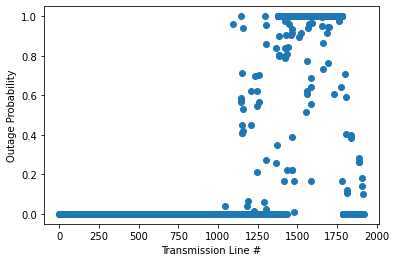

In [ ]:
import csv

outage_probability = np.piecewise(MWs_All, [MWs_All <= 43.4488, (MWs_All > 43.4488) & (MWs_All < 60.8283), MWs_All >= 60.8283], [lambda MWs_All: 0, lambda MWs_All: (MWs_All - 43.4488) / (60.8283 - 43.4488), lambda MWs_All: 1])
transmission_lines = np.arange(1,1919)
plt.xlabel('Transmission Line #')
plt.ylabel('Outage Probability')

plt.scatter(transmission_lines, outage_probability)

a_list = list(range(1, 1919))
with open('/content/drive/My Drive/WSU Summer Internship/WindSpeedPDFs500.csv', 'w', newline='') as f:
  thewriter = csv.writer(f)
  thewriter.writerow(['Transmission Line #', 'PDF Track 1', 'PDF Track 2', 'PDF Track 3'])
  for i in range(len(a_list)):

    data_1 = np.array([row[i] for row in MWs_1])
    data_2 = np.array([row[i] for row in MWs_2])
    data_3 = np.array([row[i] for row in MWs_3])

    thewriter.writerow([a_list[i], data_1, data_2, data_3])
